<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 17 - Principal component analysis 
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

- Introduction to principal component analysis
- Methods to derive principal component analysis
- Usages of principal component analysis. 

## Dimensionality reduction? 

Why do we need it? 

1. **Handling the Curse of Dimensionality** - High-dimensional data can make learning tasks more difficult because as the number of features increases, the available data becomes sparse which means distance between datapoitns is less meaningful whihc can harm a lot of algorithms.

2. **Avoid overfitting** - Too many dimensions allows ML models to overfit more easily.

3. **Improved computation efficiancy** - Last lecture we touched upon one-hot encoding which was managable when the datum where just the english alphabet. But what if the data is english words? There are about 170K english words currently in use, that would be a hell of a one-hot vector...

4. **Noise reduction** - Reducing the number of dimensions intelligently can help filter out noise by only selecting the important data characteristics for the reduced space.

5. **Visualization** - But you will see this most to assist with data visualization

Example: Andrej Karpathy interpreting a convolutional neural network embedding of images [4]: https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_6k.jpg

In [93]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
mean1 = [-2.0, -2.0]
mean2 = [2.0, 2.0]
cov = [[1, 0.8], [0.8, 1]]

X1 = np.random.multivariate_normal(mean1, cov, 40)
X2 = np.random.multivariate_normal(mean2, cov, 40)
X = np.vstack((X1, X2))

In [94]:
def plot_data_with_projection_vector(X, dv):
    # Step 1: Define projection vector
    #direction_vector = np.array([1, 1])
    direction_vector = np.array(dv)
    unit_vector = direction_vector / np.linalg.norm(direction_vector)

    # Step 2: Project points onto vector
    projections = X @ unit_vector
    projected_points = np.outer(projections, unit_vector)

    # Step 3: Choose a few sample points for red lines
    sample_indices = np.random.choice(len(X), 10, replace=False)

    # Step 4: Plot
    fig, axs = plt.subplots(3, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

    # ----- Top plot: 2D scatter -----
    ax1 = axs[0]
    ax1.scatter(X[:, 0], X[:, 1], color='blue', label='Data Points')

    # Restrict line to within [-3, 3] bounds
    x_range = np.array([-4, 4])
    line_x = x_range
    line_y = (unit_vector[1] / unit_vector[0]) * x_range
    ax1.plot(line_x, line_y, 'g--', linewidth=2, label='Projection Vector')

    # Draw red lines from selected points to their projections
    for i in sample_indices:
        x0, y0 = X[i]
        x1, y1 = projected_points[i]
        ax1.plot([x0, x1], [y0, y1], 'r-', linewidth=2)

    # Set axis limits *after* drawing everything
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_title('PCA Projection with Two Clusters')
    ax1.legend()
    ax1.grid(True)
    ax1.set_aspect('equal')

    # ----- Middle plot: 1D projected values -----
    ax2 = axs[1]
    ax2.scatter(projections, np.zeros_like(projections), color='purple', s=30, alpha=0.7)
    ax2.set_xlim(-5, 5)
    ax2.set_yticks([])
    ax2.set_xlabel('Projection onto vector')
    ax2.set_title('1D Distribution of Projected Points')
    ax2.grid(True)

    # ----- Middle plot: histogram of projected values -----
    ax3 = axs[2]
    plt.hist(projections, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel("Projection Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Projected Data (1D)")
    ax3.grid(True)

    
    
    
    plt.tight_layout()
    plt.show()

    proj_variance = np.var(projected_points)
    print("Variance of projected points:", proj_variance)

If we choose our projection vector correctly, the reduced samples can still give a good perspective on the data characteristics.

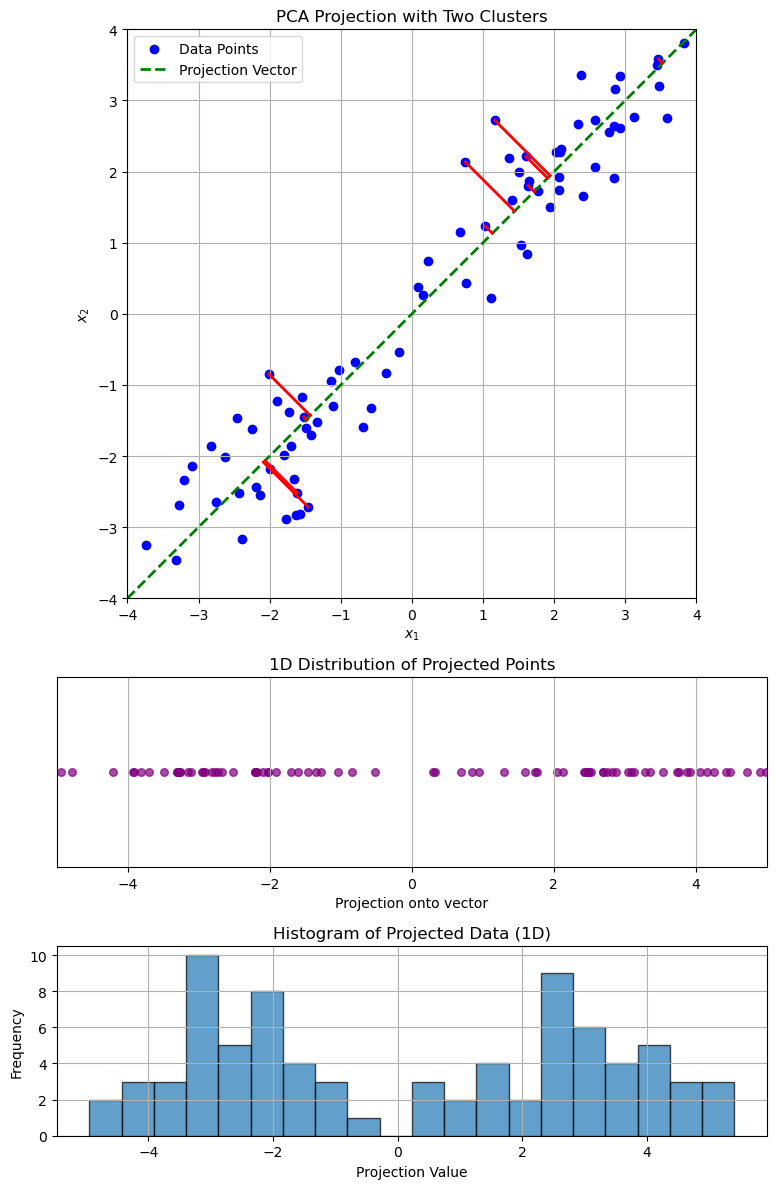

Variance of projected points: 4.558023516601454


In [95]:
plot_data_with_projection_vector(X,[1,1])

If we choose our projection vector poorly, then the reduced data points eliminate some crucial information. 

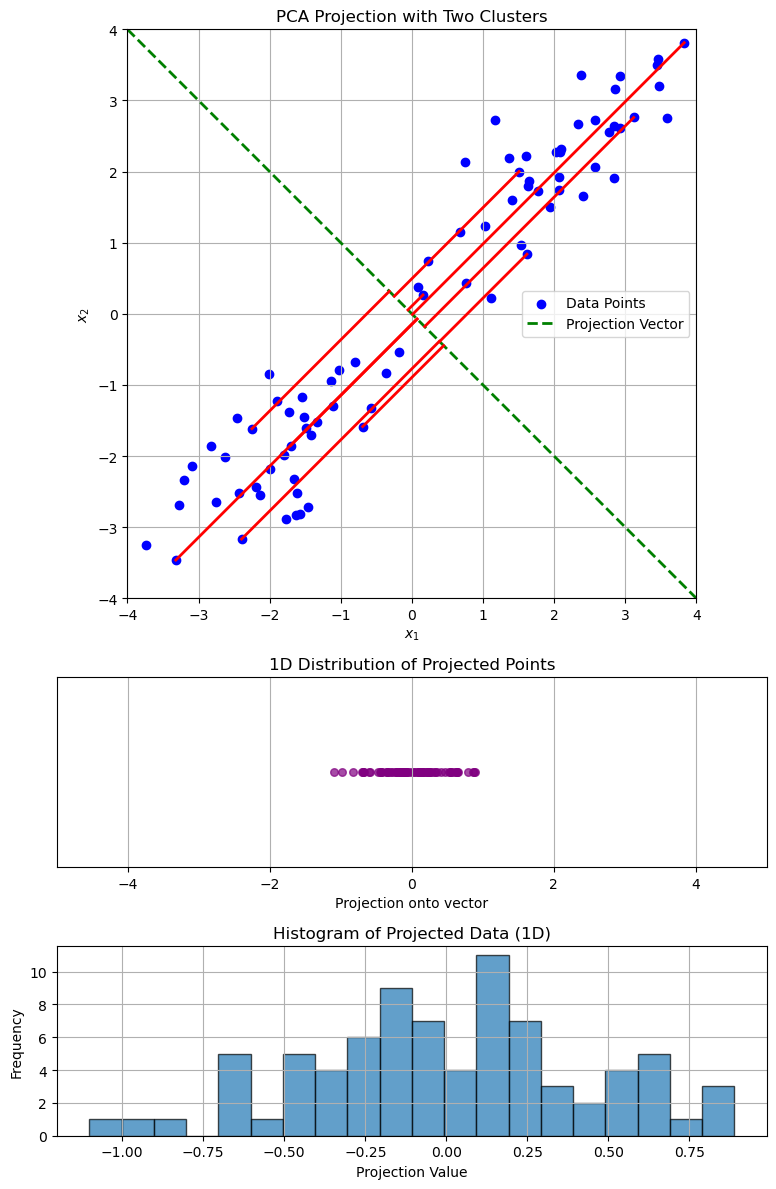

Variance of projected points: 0.09342643900843979


In [96]:
plot_data_with_projection_vector(X,[1,-1])

### Interpreatations of principal component analysis

Looking at the graphs there seem to be two things that we want our projected samples to do: 

1. We want to maximize the variance of the reduced points
2. We want to preserve as much information as possible to make reconstruction of the original data easier. 

Turns out boths these desires are equivalent and can be used to derive the dimensionality reduction technique we are going to discuss next. 

## Essential math skills

### Matrix Calculus

We've gone over matrix calculus in previous lectures but as a reminder, the two important ones are: 

- $$ \frac{\partial x^T x}{\partial x} = 2 x $$

- Vector sum reduction: 
$$
y = sum(X)
$$

$$
\begin{matrix}
\frac{\partial y}{\partial x} &= \left[ \frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2}, \dots, \frac{\partial y}{\partial x_n} \right] \\ 
&=\left[\frac{\partial}{\partial x_1} \Sigma^n_i x_i, \frac{\partial}{\partial x_1} \Sigma^n_i x_i, \dots, \frac{\partial}{\partial x_n} \Sigma^n_i x_i   \right] \\
&=\left[\frac{\partial x_1}{\partial x_1}, \frac{\partial x_2}{\partial x_2}, \dots, \frac{\partial x_n}{\partial x_n} \right] \\
&=\left[1,1, \dots, 1\right] = \overrightarrow{1}^T
\end{matrix}
$$


### Eigenvalues & Eigenvectors Overview

- **Definition:**  
  For a square matrix **A**, a nonzero vector **v** is an **eigenvector** if it satisfies:  
  **A·v = λ·v**  
  where **λ** is a scalar called the **eigenvalue** associated with **v**.

- **Key Ideas:**  
  - **Scaling:** The action of **A** on **v** only scales **v** by **λ**; it doesn’t change its direction.  
  - **Characteristic Equation:** Eigenvalues are found by solving:  
    **det(A – λI) = 0** where **I** is the identity matrix.

- **Interpretation:**  
  Eigenvectors point in directions that remain invariant under the transformation **A**, while eigenvalues indicate how much they are stretched or compressed.

An excellent video on eigenvalues/vectors by 3Blue1Brown: https://www.youtube.com/watch?v=PFDu9oVAE-g

### Lagrange Multipliers Overview

- **Purpose:**  
  A method for finding local extrema of a function subject to equality constraints.

- **The Method:**  
  - Given an objective function **f(x, y, ...)** and a constraint **g(x, y, ...) = 0**,  
    form the **Lagrangian:**  
    **L(x, y, ..., λ) = f(x, y, ...) - λ · g(x, y, ...)**
  - Compute the partial derivatives with respect to all variables (including **λ**) and set them to zero:
    - **∂L/∂x = 0**
    - **∂L/∂y = 0**
    - **∂L/∂λ = 0**

- **Geometric Insight:**  
  At the optimum, the gradients of **f** and **g** are parallel:
  **∇f = λ · ∇g**

- **Example:**  
  To minimize **f(x, y) = x² + y²** subject to **x + y = 1**, use the Lagrangian:
  **L(x, y, λ) = x² + y² - λ(x + y - 1)**
  
An excellent video on Legrange multipliers by Casual Science: https://www.youtube.com/watch?v=s8j-pI_tPlM  

Legrange multipliers are used in duel optimization whihc we didn't cover in this course but is important in other parts of machine learning. 

## Principal Component Analysis

*Big thanks to Herman Kamper for his excellent PCA lecture(s) [3]

### First let's talk about projections: 

<img align="right" src="img/proj_overall.png" width="400px" style="padding:30px;border:thin solid white;"> 
First let's talk about projections and the notations we will use. 

We want to project a datapoint of dimension D  ($x^{(n)} \in \mathbb{R}^D$) to a new point of dimension M ($z^{(n)} \in \mathbb{R}^M$) assuming that $M<D$.

*We can also assume the data has been normalized to have zero mean (see batch-normalization from the previosu lecture.*

So let's define $M$ "projection vectors" ($w_1-w_M$) of dimension $D$ ($w_m \in \mathbb{R}^D$)
* projections vectors are unit length ($\vert\vert w_m \vert\vert = 1$)
* projection vectors are orthogonal ($w_i^T w_j = 0 \quad \forall i, j \in M, i \neq j$)

<br>

<img align="left" src="img/proj_not.png" width="200px" style="padding:30px;border:thin solid white;"> 

Using the projection vectors, we know that the datapoint $x^{(n)}$ can be projected onto the m-th dimension using: 

$$$z^{(n)}_m = w^{T}_m x^{(n)}$$

Hence by using this for every dimension we can get $z^{(n)}$. 


There's a way to write this in matrix form: 


$$z^{(n)} = 
\begin{bmatrix}
z_{1}^{(n)} \\
z_{2}^{(n)} \\
\vdots \\
z_{M}^{(n)}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{w}_1^T \mathbf{x}_c^{(n)} \\
\mathbf{w}_2^T \mathbf{x}_c^{(n)} \\
\vdots \\
\mathbf{w}_M^T \mathbf{x}_c^{(n)}
\end{bmatrix}
=
\begin{bmatrix}
\ldots \mathbf{w}_1^T \ldots \\
\ldots \mathbf{w}_2^T \ldots \\
\vdots \\
\ldots \mathbf{w}_M^T \ldots
\end{bmatrix}_{M \times D}
\times
\begin{bmatrix}
x_1^{(n)} \\
x_2^{(n)} \\
\vdots \\
x_D^{(n)}
\end{bmatrix}_{D \times 1}
= W^T x^{(n)}
$$

Hence our projection matrix is: 

$$
W = 
\begin{bmatrix}
\vdots & \vdots & & \vdots \\
\mathbf{w}_1 & \mathbf{w}_2 & \cdots & \mathbf{w}_M \\
\vdots & \vdots & & \vdots
\end{bmatrix}
$$

### Reconstruction 

<img align="center" src="img/reconstruction.png" width="800px" style="padding:30px;border:thin solid white;"> 

Can reconstruct the image using: $\hat{x}^{(n)} = W z^{(n)}$

### Principal component analysis

We want to find the projection vectors. But what should our criteria be? 

Remember in a previous lecture, seems like it is best when variance is maximized so let's go with that. 

Covariance of the projected points $\left\{ z^{(1)} \ldots z^{(N)} \right\}$ is given as: 

$$
\begin{aligned}
\hat{\sigma}_{z_i}^2 
&= \frac{1}{N} \sum_{n=1}^N \bigl(z_i^{(n)} - \bar{z}_i\bigr)^2 \text{we know } \bar{z}_i = 0 \\
&= \frac{1}{N} \sum_{n=1}^N \bigl(w_i^T \mathbf{x}^{(n)}\bigr)^2 \\
&= \frac{1}{N} \sum_{n=1}^N \bigl(w_i^T \mathbf{x}^{(n)}\bigr)
    \bigl(w_i^T \mathbf{x}^{(n)}\bigr)^T \\
&= w_i^T \left[
    \frac{1}{N} \sum_{n=1}^N \mathbf{x}^{(n)} \bigl(\mathbf{x}^{(n)}\bigr)^T   
\right] w_i \text{if $x$ is normalized (zero-mean) stuff in brackets is simply covariance matrix}\\
&= w_i^T \mathbf{\Sigma} w_i
\end{aligned}
$$

Wan to maxmize $\hat{\sigma}_{z_i}^2$ but we also need to make sure projection vectors are unit length - $\vert\vert w_m \vert\vert^2 = 1$

This is where we need legrange multipliers. Couple notes: 
- Maximizing $\hat{\sigma}_{z_i}^2$ is the same as minimizing $-\hat{\sigma}_{z_i}^2$
- Can add constraint to minimization function

$$ \begin{align}
J\left(w_i, \lambda\right) &= -\hat{\sigma}_{z_i}^2 + \lambda\left(w_i^T w_i - 1\right) \\
&= w_i^T \sum_{n=1}^N w_i + \lambda\left(w_i^T w_i - 1\right)
\end{align}
$$

if we minimize this function with respect to $w_i$

$$
\frac{\partial J}{\partial w_i} = -2 \mathbf{\Sigma} + 2 \lambda w_i = 0
$$

$$
\mathbf{\Sigma} w_i = \lambda w_i
$$

This looks an aweful lot like the eigenvalue equation (**A·v = λ·v**). So what does this mean?

$$
\begin{align} 
w_i^T \mathbf{\Sigma} w_i &= \lambda w_i^T w_i \\
w_i^T \mathbf{\Sigma} w_i &= \lambda \\
\hat{\sigma}_{z_i}^2 = \lambda \\
\end{align}
$$

So this means that the variance is maxmized when projection vectors correspond to the eigenvectors of the data's covariance matrix.

## Complete Principal component analysis process (with example)

### Step 1: Normalize data 

Data has to be zero mean so that: 

$$
\frac{1}{N} \sum_{n=1}^N \mathbf{x}^{(n)} \bigl(\mathbf{x}^{(n)}\bigr)^T = \mathbf{\Sigma}  
$$

This is easy to accomplish: 

$$
\begin{align}
\mathbf{X} 
&= 
\begin{bmatrix}
\,| &       & |\, \\
\mathbf{x}^{(1)} & \cdots & \mathbf{x}^{(N)} \\
\,| &       & |\, 
\end{bmatrix}\\
\tilde{\mathbf{X}}
&=
\begin{bmatrix}
\,| &       & |\, \\
\mathbf{x}^{(1)} - \boldsymbol{\mu} & \cdots & \mathbf{x}^{(N)} - \boldsymbol{\mu} \\
\,| &       & |\, 
\end{bmatrix}
\quad\text{where}\quad
\boldsymbol{\mu} 
= \frac{1}{N} \sum_{i=1}^N \mathbf{x}^{(i)}.
\end{align}
$$

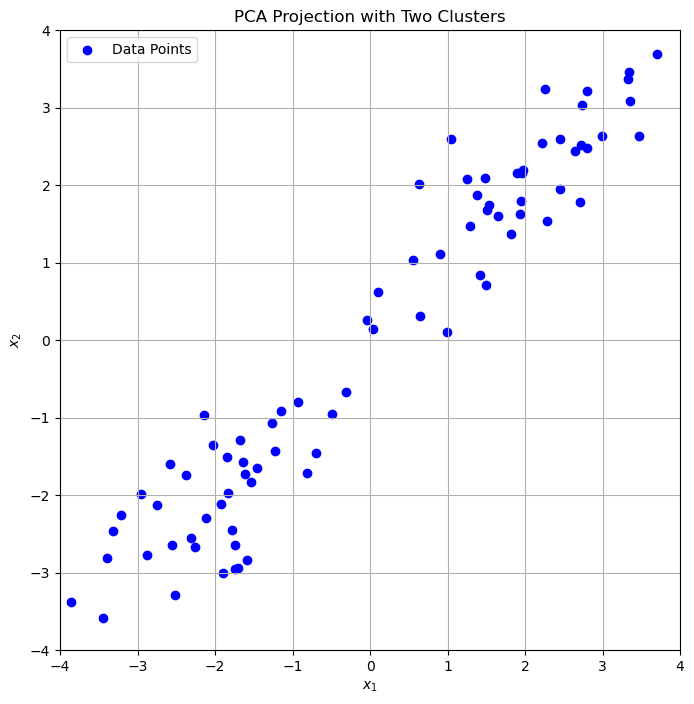

In [97]:
#let's first look at the data we have

mean = np.mean(X, axis=0)
X_norm = X - mean
#X_norm = X - np.expand_dims(mean, axis=1)

fig, axs = plt.subplots(1, 1, figsize=(8, 10))
#axs.scatter(X_norm[0, :], X_norm[1, :], color='blue', label='Data Points')
axs.scatter(X_norm[:, 0], X_norm[:, 1], color='blue', label='Data Points')
axs.set_xlim(-4, 4)
axs.set_ylim(-4, 4)
axs.set_xlabel('$x_1$')
axs.set_ylabel('$x_2$')
axs.set_title('PCA Projection with Two Clusters')
axs.legend()
axs.grid(True)
axs.set_aspect('equal')

### Step 2: Calculate sample covariance matrix

Pretty simple formula: 

$$
\mathbf{\Sigma} = \frac{1}{N} \sum_{n=1}^N \mathbf{x}^{(n)} \bigl(\mathbf{x}^{(n)}\bigr)^T = \frac{1}{N} X^T X 
$$

Although as usual, Python has a nice little function for that: 

In [98]:
cov_matrix_manual = 1.0/X_norm.shape[1] * X.T @ X
print("Manual calculation for covariance matrix")
print(cov_matrix_manual)

cov_matrix = np.cov(X_norm, rowvar=False)
print("NumPy calculation for covariance matrix")
print(cov_matrix_manual)


Manual calculation for covariance matrix
[[183.88177812 179.19364976]
 [179.19364976 189.45375163]]
NumPy calculation for covariance matrix
[[183.88177812 179.19364976]
 [179.19364976 189.45375163]]


### Step 3: Find D eigenvalue-eigenvector pairs


Given a square matrix $A$, an eigenvector $v$ and eigenvalue $\lambda$ satisfy:

$$
A v = \lambda v
$$

This means: multiplying $A$ by $v$ just scales $v$ — it doesn’t change its direction.

---

1. Start from the eigenvalue equation:  
   $$
   A v = \lambda v \Rightarrow (A - \lambda I) v = 0
   $$

2. This is a homogeneous system — for non-trivial $v$, the matrix must be singular:  
   $$
   \det(A - \lambda I) = 0
   $$

3. Solve the determinant equation (a polynomial in $\lambda$):  
   - This gives the **eigenvalues**.

4. Plug each $\lambda$ into $(A - \lambda I) v = 0$:  
   - Solve for $v$ → the **eigenvectors**.

---

So we can do all that ... or:

In [99]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

for idx, ev in enumerate(eigenvalues): 
    print("For λ = " + str(ev) + ": v = " + str(eigenvectors[:, idx]))

For λ = 0.18865654178115854: v = [-0.71263138  0.70153868]
For λ = 9.231996415562412: v = [-0.70153868 -0.71263138]


### Step 4: Chose the M eigenvectors corresponding to the highest eigenvalues

In [100]:
max_index = np.argmax(eigenvalues)
principal_component = eigenvectors[:, max_index]

print("Using λ = " + str(eigenvalues[max_index]) + " which corresponds to v = " + str(eigenvectors[:, max_index]))

Using λ = 9.231996415562412 which corresponds to v = [-0.70153868 -0.71263138]


### Step 5: Project data into lower dimensional space

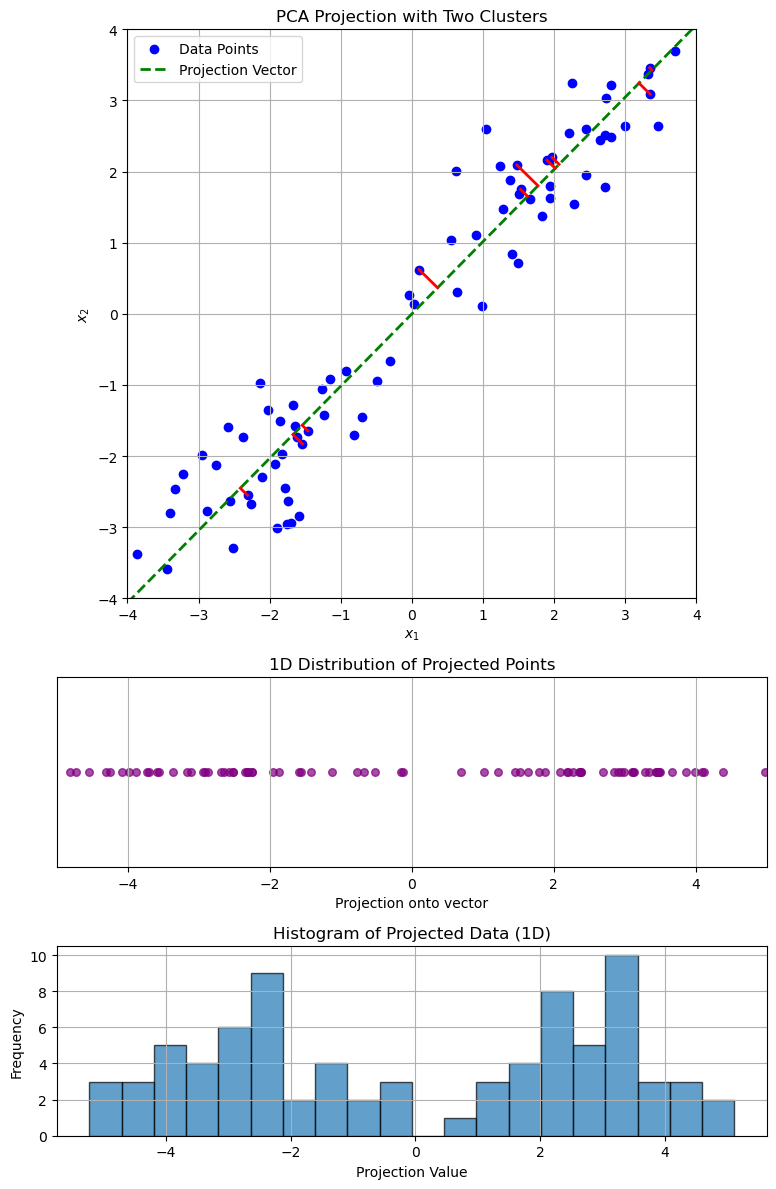

Variance of projected points: 4.558298230183942


In [101]:
plot_data_with_projection_vector(X_norm,principal_component)

### Or we can just use PyTorch

I mean, a major objective is to learn PyTorch right? 

(80, 2)
v = tensor([-0.7015, -0.7126], dtype=torch.float64)


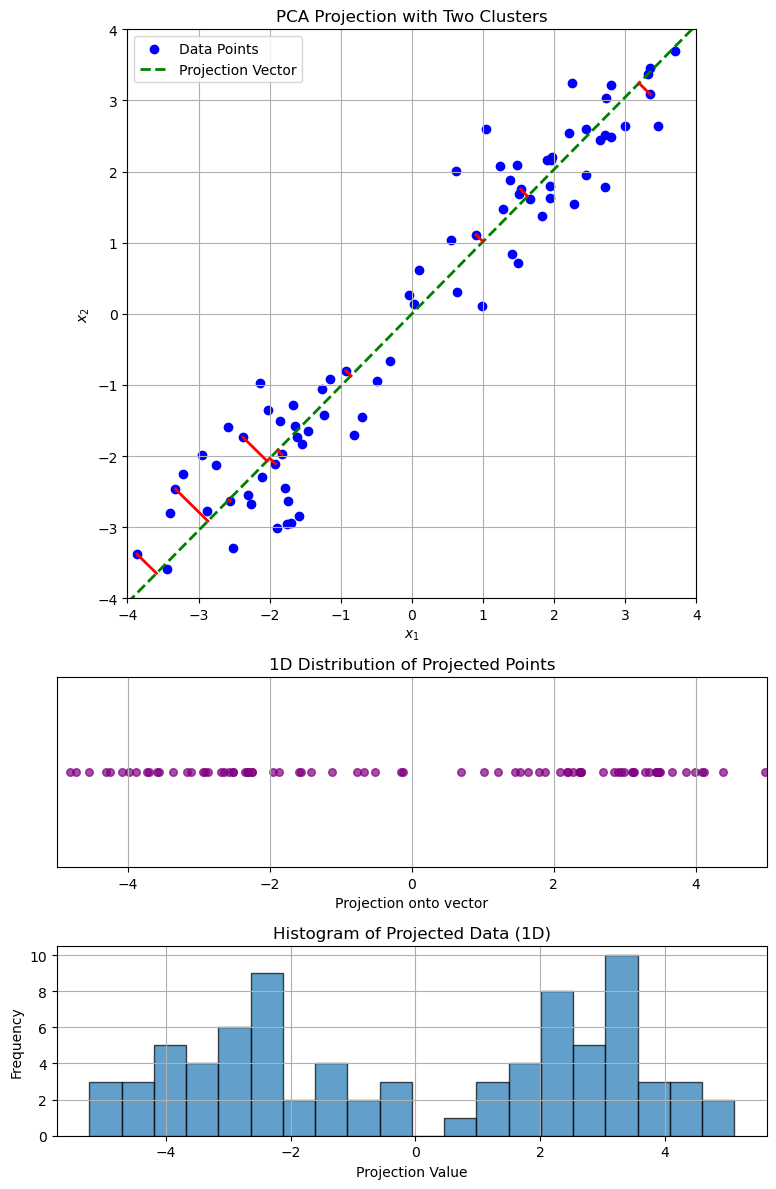

Variance of projected points: 4.55829823018239


In [102]:
import torch 
print(X.shape)
U, S, V = torch.pca_lowrank(torch.tensor(X), q=1, center=True)
# The principal component is in V. V has shape (num_features, q) so we extract the first column.
principal_component = V[:, 0]

print("v = " + str(principal_component))

plot_data_with_projection_vector(X_norm,principal_component)

#### Side-note

The torch function outputs U,S,V matrices because it uses a mathematical technique called singular value decomposition that reduces the a matrix into a a rotation, scaling and reflection matrix. 

If you'd like to know more about what these U, S, and V vectors are refer to Wikipedia [5].

If you'd like to know more about how PCA relates to SVD, refer to Herman Kempar's excellent PCA lecture [6]. 

## What is PCA good for? 

We discussed this in the beginning of the lecture but let's see if we can figure out a example ourselves.

Let's follow Karpathy's footsteps and use Dimensionality reduction can be used for unsupervised learning: 

/var/folders/dl/klptcn0j6cz_5lxgh6mxyd_r0000gn/T/ipykernel_63773/2219847756.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)


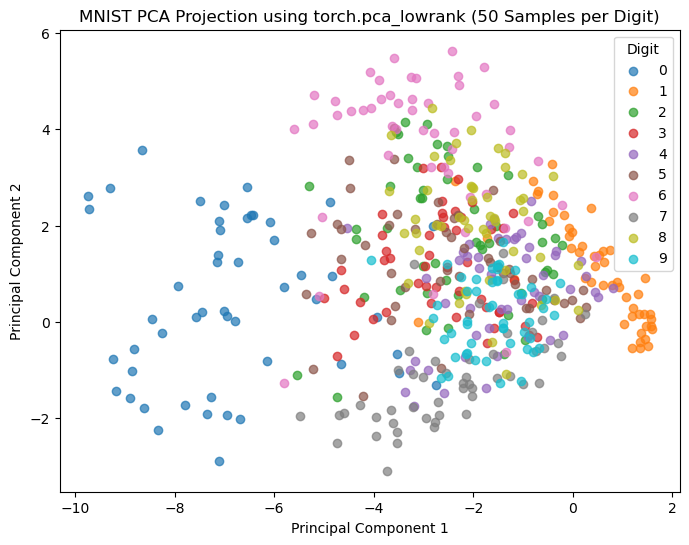

In [103]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a transform to convert images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Download MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Sample 50 images per digit (0-9)
num_samples_per_class = 50
selected_images = []
selected_labels = []
count = {i: 0 for i in range(10)}

# Loop through the dataset until we have 50 samples per class
for img, label in train_dataset:
    if count[label] < num_samples_per_class:
        selected_images.append(img)  # img shape: [1, 28, 28]
        selected_labels.append(label)
        count[label] += 1
    if all(c >= num_samples_per_class for c in count.values()):
        break

# Convert images to a tensor and flatten each image to a vector of size 784 (28x28)
X = torch.stack([img.view(-1) for img in selected_images])  # Shape: (500, 784)
y = torch.tensor(selected_labels)

# Use torch.pca_lowrank to compute the top 2 principal components
U, S, V = torch.pca_lowrank(X, q=2)

# Project the data onto the principal components
X_pca = X @ V  # Shape: (500, 2)

# Convert to NumPy arrays for plotting
X_pca_np = X_pca.detach().numpy()
y_np = y.detach().numpy()

# Use a discrete colormap with exactly 10 colors ('tab10')
cmap = plt.cm.get_cmap('tab10', 10)

plt.figure(figsize=(8, 6))

# Plot each digit class separately to create a legend entry for each
for digit in range(10):
    idx = (y_np == digit)
    plt.scatter(X_pca_np[idx, 0], X_pca_np[idx, 1], 
                c=[cmap(digit)], alpha=0.7, label=str(digit))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("MNIST PCA Projection using torch.pca_lowrank (50 Samples per Digit)")
plt.legend(title="Digit")
plt.show()

### What are the eigenvectors actually doing? 

Here's a neat way to visualize the eigenvectors: 

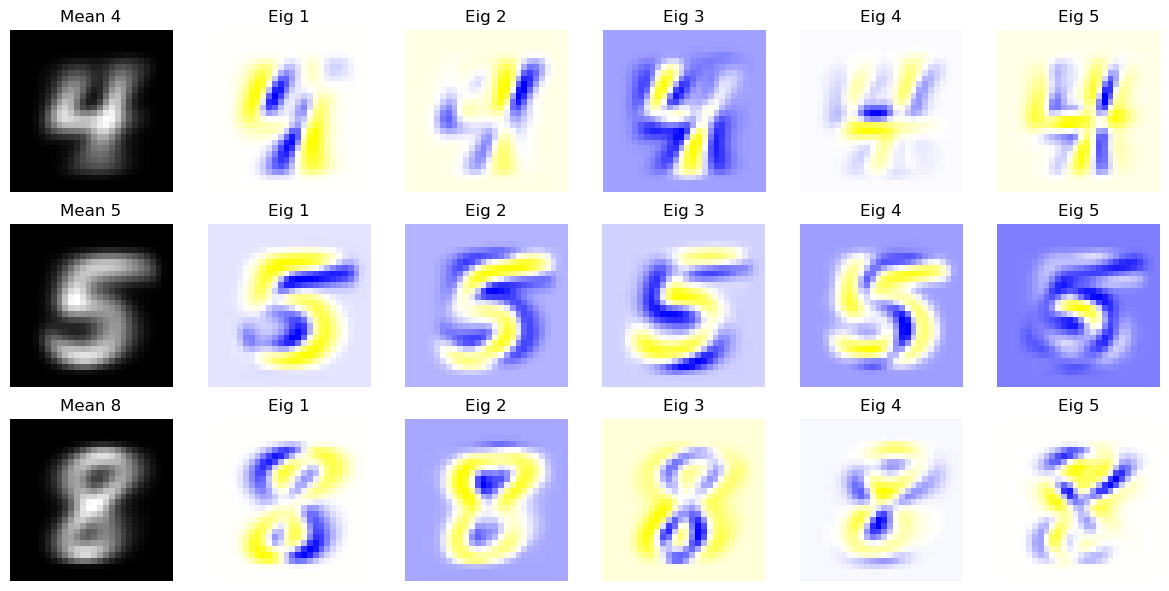

In [104]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap: yellow for negative, white for near zero, blue for positive.
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["yellow", "white", "blue"])

# Define the transformation and download the MNIST training dataset
transform = transforms.ToTensor()
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Select the classes of interest: 4, 5, and 8
classes = [4, 5, 8]
data_by_class = {c: [] for c in classes}

# Group images by label for the selected classes
for img, label in mnist:
    if label in classes:
        # Squeeze to remove the channel dimension (1, 28, 28) -> (28, 28)
        data_by_class[label].append(img.squeeze())

# Convert lists to tensors (shape: (N, 28, 28) for each class)
for c in classes:
    data_by_class[c] = torch.stack(data_by_class[c])

# Dictionary to store the mean images and PCA eigenvectors per class
results = {}

for c in classes:
    images = data_by_class[c]  # shape: (N, 28, 28)
    N = images.shape[0]
    # Flatten images to shape (N, 784)
    X = images.view(N, -1)
    
    # Compute the mean image for the class
    mean_image = X.mean(dim=0)
    
    # Compute PCA using torch.pca_lowrank
    # center=True will center the data internally.
    # q=5 asks for the top 5 principal components.
    U, S, V = torch.pca_lowrank(X, q=5, center=True)
    # V has shape (784, 5), so its columns are the eigenvectors.
    # Transpose V to iterate over the eigenvectors.
    eigvec_images = [v.reshape(28, 28) for v in V.t()]
    
    # Store the results
    results[c] = {"mean": mean_image.reshape(28, 28), "eigvecs": eigvec_images}

# Create a grid for visualization: 3 rows (for digits 4, 5, and 8) and 6 columns (1 for the mean image + 5 for eigenvectors)
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 6))

for i, c in enumerate(classes):
    row = axes[i]
    
    # First column: mean image (displayed in grayscale)
    ax = row[0]
    ax.imshow(results[c]["mean"].numpy(), cmap='gray')
    ax.set_title(f"Mean {c}")
    ax.axis('off')
    
    # Next 5 columns: top 5 eigenvectors using the custom colormap
    for j in range(5):
        ax = row[j+1]
        ax.imshow(results[c]["eigvecs"][j].numpy(), cmap=custom_cmap)
        ax.set_title(f"Eig {j+1}")
        ax.axis('off')

plt.tight_layout()
plt.show()

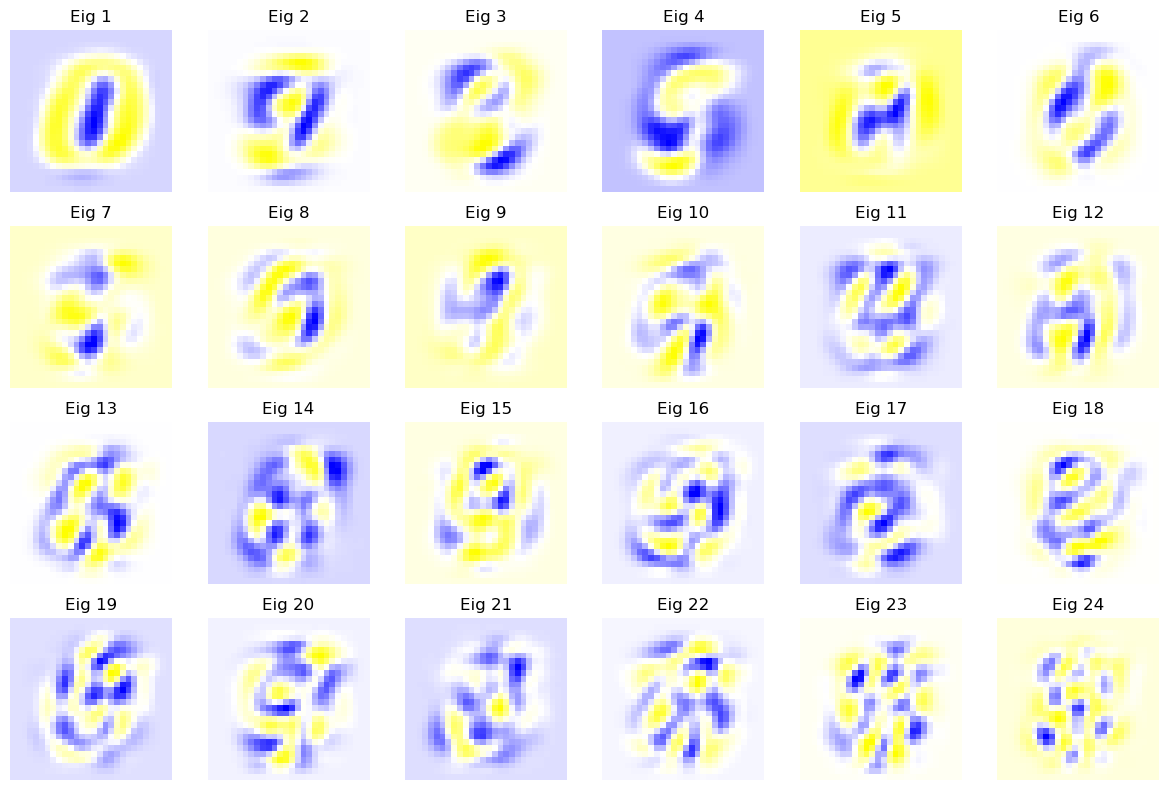

In [105]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap: yellow for negative, white for near zero, blue for positive.
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["yellow", "white", "blue"])

# Define transformation and download the MNIST training dataset.
transform = transforms.ToTensor()
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Use the entire training dataset. mnist.data is a tensor of shape (60000, 28, 28) with uint8 values.
global_images = mnist.data.float() / 255.0  # Normalize to [0, 1]
N_global = global_images.shape[0]
X_global = global_images.view(N_global, -1)  # Flatten to (60000, 784)

# Compute PCA using torch.pca_lowrank.
# Set q=24 to obtain the top 24 eigenvectors.
# The function centers the data internally when center=True.
U, S, V = torch.pca_lowrank(X_global, q=24, center=True)
# V has shape (784, 24); its columns are the principal components.

# Extract eigenvectors as images.
# Iterate over the rows of V.t() (which gives 24 vectors of length 784).
eigvec_images = [v.reshape(28, 28) for v in V.t()]

# Create a 4x6 plot matrix to display the 24 eigenvectors.
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8))
axes = axes.flatten()

for i in range(24):
    ax = axes[i]
    ax.imshow(eigvec_images[i].numpy(), cmap=custom_cmap)
    ax.set_title(f"Eig {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## That's it for today

- Next time we are going to discuss K-means clustering.
- Homework 7 due Monday.
- Homework 8 will be posted by tomorrow. 
- Project coming by this weekend. One of the topics is just giving us issues but I promise I will either fix it or toss it by this weekend. 

## References

[1] Kashnitsky, Yury (mlcourse.ai) "Unsupervised learning: PCA and clustering" - https://www.kaggle.com/code/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering

[2] Erdem, Kemel "t-SNE clearly explained" - https://medium.com/data-science/t-sne-clearly-explained-d84c537f53a

[3] Herman Kamper "Data414 - Lectures" - https://www.kamperh.com/data414/

[4] Karpathy, Andrej - https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_6k.jpg

[5] Wikipedia "Singular value decomposition" - https://en.wikipedia.org/wiki/Singular_value_decomposition

[6] Kamper, Herman "PCA 6 - Relationship to SVD" - http://youtube.com/watch?v=DQ_BkPHIl-g&list=PLmZlBIcArwhMfNuMBg4XR-YQ0QIqdHCrl